[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gsarti/ik-nlp-tutorials/blob/main/notebooks/W4E_NonTextual_Information.ipynb)

In [2]:
# Run in Colab to install local packages
!pip install spacy transformers sentencepiece datasets scikit-learn pandas
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 88.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Combining Textual and Non-textual Features in NLP Models

*Based on the Text Classification tutorial by [Debora Nozza](https://dnozza.github.io/)*

In many real-world applications, text is just one of the multiple sources of information that can be used to predict desired quantities. In this exercise, you will reproduce a standard machine learning pipeline integrating text and non-textual information. Importantly, while in the previous tutorials and exercises we focused on the usage of advanced tooling such as the Transformers library, here we will start from the basics to establish some baseline results using the popular [Scikit-learn](https://scikit-learn.org/stable/index.html) library.

**Exercise 1**, which is mandatory and will be part of your graded midterm portfolio, will include the following steps:

1. Preprocess the text to extract lemmatized content words.

2. Converting the text to a vector representation using simple count-based approaches.

3. Convert categorical features into one-hot vectors.

4. Fit a simple model to predict the desired target.

5. Establish a simple baseline performance for the prediction task.

6. Evaluate the model performance on a held-out set.

7. Perform a feature selection and re-evaluate the model

8. Obtain insights about salient words and features for the prediction task.

Every operation to be completed is marked with a `TODO` comment in the code section. While these represent a small but nonetheless comprehensive set of steps to train models on textual and non-textual information, nowadays NLP practitioners operate mainly with pre-trained word embeddings for representing textual information.


# Exercise 1: A Simple Wine Scoring Pipeline

In this exercise, we will use a filtered version of the [Winemag dataset](https://www.kaggle.com/zynicide/wine-reviews) containing a collection of wine reviews (`description`), accompanied by some metadata: `country` and `province` of provenance, `variety` of wine, `price` per bottle and the WineEnthusiast rating (`points`) describing the wine quality.

*Your final goal is to build and evaluate a simple linear regression model that predicts the `points` assigned to a wine given its `description` and its other features.* This is commonly known as a **regression problem**, since you are trying to predict a continuous quantity, as opposed to a discrete one (e.g. a class label).

Most importantly, the general procedure and methods you will use can be applied to any kind of data with the adequate preprocessing, and can be extended to other tasks such as binary and multiclass classification.

You can have a look at the data, which has been conveniently packed into a Huggingface Dataset object:

In [3]:
from datasets import load_dataset

data = load_dataset("GroNLP/ik-nlp-22_winemag")
print(data)
data["train"].to_pandas().head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/33.0 [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

validation.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/70458 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['index', 'country', 'description', 'points', 'price', 'province', 'variety'],
        num_rows: 70458
    })
    validation: Dataset({
        features: ['index', 'country', 'description', 'points', 'price', 'province', 'variety'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['index', 'country', 'description', 'points', 'price', 'province', 'variety'],
        num_rows: 5000
    })
})


,index,country,description,points,price,province,variety
0,129857,US,Dusty tannins make for a soft texture in this ...,90,44.0,California,Merlot
1,112217,US,Sweet-tart Maraschino cherry and bitter brambl...,85,14.0,New York,Pinot Noir
2,114216,France,A lightly orange-colored rosé that is made by ...,92,90.0,Champagne,Champagne Blend
3,37808,France,"A ripe wine that is almost off dry, this has a...",85,17.0,Bordeaux,Bordeaux-style Red Blend
4,31157,US,"Crisp and very floral, this is a beautiful sho...",92,20.0,California,Pinot Gris


### Text Preprocessing

Text is messy. The goal of preprocessing is to reduce the amount of noise (= unnecessary variation), while maintaining the signal. There is no one-size-fits-all solution, but a good approximation can be, for example, to preserve only content words and reduce the size of the vocabulary by means of a lemmatizer.

You learned how to extract lemmas and POS tags using spaCy, and how to use `.map` to apply a function to a `Dataset`, so you should have all the tools to succeed in this. Fill in the missing code:

In [4]:
import spacy

# Disable unused components
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def clean_text(text):
    '''Reduce text to lower-case lemmatized content words.'''
    content_op = ['NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN']
    # Extract lemmas for content words only, lowercase, and exclude punctuation/space
    doc = nlp(text)
    lemmas = [
        token.lemma_.lower()
        for token in doc
        if token.pos_ in content_op and not token.is_punct and not token.is_space
    ]
    return ' '.join(lemmas)

clean_text('This is a test sentence. And here comes another one... Go me!')

'test sentence here come one go'

Let's now apply this cleaning function to the `description` column of the dataset:

In [5]:
for split in data.keys():
    # Apply the clean_text function to the
    # description column, mapping the output to a new clean_text column
    # and removing the original description column.
    data[split] = data[split].map(
        lambda x: {"clean_text": clean_text(x["description"])},
        remove_columns = ["description"]
    )

Map:   0%|          | 0/70458 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

### Representing Text

Now that you have a more compact representation of the text, the next step is converting it into a vector representation. For this purpose, you will use the [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class provided by Scikit-learn. This class converts a collection of text documents to a matrix of [TF-IDF scores](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) reflecting the importance of a word in a document, and in relation to the full corpus. We are going to set some parameters to ensure a limited size of the vocabulary, but you can experiment with other values.

In [6]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    ngram_range=(1,2),   # Use 1-grams and 2-grams
    min_df=0.001,        # Ignore terms that appear in <0.1% of documents
    max_df=0.75,         # Ignore terms that appear in >75% of documents
    max_features=1000,   # Keep only top 1000 features
    stop_words='english'
)

# Convert splits to pandas
train_df = data["train"].to_pandas()
val_df = data["validation"].to_pandas()
test_df = data["test"].to_pandas()

# Fit only on training data
X_train = vectorizer.fit_transform(train_df["clean_text"]).toarray()

# Transform the other splits
X_val = vectorizer.transform(val_df["clean_text"]).toarray()
X_test = vectorizer.transform(test_df["clean_text"]).toarray()

# Converting the training vectors to a pandas dataframe
text_vectors = pd.DataFrame(
    X_train,
    columns=["w_" + w for w in vectorizer.get_feature_names_out()]
)

text_vectors.head()

,w_accent,w_accessible,w_accompany,w_acid,w_acidic,w_acidity,w_acidity drink,w_acidity finish,w_acidity wine,w_add,...,w_yeasty,w_yellow,w_yellow fruit,w_young,w_young wine,w_youthful,w_zest,w_zesty,w_zin,w_zinfandel
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.121625,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Categorical -> One-Hot Conversion

Many of the available features in the datasets are categorical, and you will need to convert them to [one-hot vectors](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) in order to use them in a regression model. Luckily, the [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) class is readily available in Scikit-learn for this purpose. An even more convenient approach is to use the [`pandas.get_dummies`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) function, which returns a pandas Dataframe with labeled one-hot encoded columns,

In [7]:
# Encode the fields country, province and variety of each data split separately into one-hot vectors using pd.get_dummies()

# Train
country_train = pd.get_dummies(train_df["country"], prefix="country")
province_train = pd.get_dummies(train_df["province"], prefix="province")
variety_train = pd.get_dummies(train_df["variety"], prefix="variety")

# Validation
country_val = pd.get_dummies(val_df["country"], prefix="country")
province_val = pd.get_dummies(val_df["province"], prefix="province")
variety_val = pd.get_dummies(val_df["variety"], prefix="variety")

# Test
country_test = pd.get_dummies(test_df["country"], prefix="country")
province_test = pd.get_dummies(test_df["province"], prefix="province")
variety_test = pd.get_dummies(test_df["variety"], prefix="variety")

# Train variables
country_vectors = country_train
province_vectors = province_train
variety_vectors = variety_train

print("Country train shape:", country_train.shape)
print("Province train shape:", province_train.shape)
print("Variety train shape:", variety_train.shape)

country_train.head()

Country train shape: (70458, 8)
Province train shape: (70458, 21)
Variety train shape: (70458, 32)


,country_Argentina,country_Australia,country_France,country_Germany,country_Italy,country_Portugal,country_Spain,country_US
0,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,True
2,False,False,True,False,False,False,False,False
3,False,False,True,False,False,False,False,False
4,False,False,False,False,False,False,False,True


### Putting it all Together and Fitting a Model

Now that all the data is ready to be processed, create two Pandas dataframes to train the model: `features` should be the concatenation of the `price` field plus all the vectorized features (`text_vectors`, `country_vectors`, `province_vectors`, `variety_vectors`), while `target` should be a single column of `points` field.

Finally, you will train a simple linear model using the `fit` method of an instance of the [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model, which fits a regular least-squares linear regression to the features. A regression model is simply a function that takes a set of numeric values, called **features**, as input, and returns an output score. Fitting a model is the process of finding the right parameters, called **weights**, to map the input features to the output targets.

In [11]:
# Create the features and target dataframes for the train split

features = pd.concat(
    [
        train_df[["price"]],
        text_vectors,
        country_train,
        province_train,
        variety_train
    ],
    axis=1
)

target = train_df["points"]

print("Features shape:", features.shape)
print("Target shape:", target.shape)

from sklearn.linear_model import LinearRegression

regressor = LinearRegression(n_jobs=-1)
regressor.fit(features, target)
print(regressor)

Features shape: (70458, 1062)
Target shape: (70458,)
LinearRegression(n_jobs=-1)


### A Simple Baseline

Before evaluating the performance of your fitted model, you might want to establish a reasonable **baseline**, representing a null-hypothesis choice. In the case of regression, usually a simple statistical baseline is the mean of the targets, minimizing the prediction error in absence of any information but the distribution of target values. The Scikit-learn library implements a [`DummyRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) that can be used to fit various regression baselines, including the mean.

In [12]:
from sklearn.dummy import DummyRegressor

baseline = DummyRegressor(strategy="mean")

# Fit the baseline to the same data used with the regressor
baseline.fit(features, target)

print(baseline)

DummyRegressor()


### Evaluation

Having a model is great, but how well does it do? Can it predict what it has seen? We need a way to estimate how well the model will work on new data. We will use two metrics: the [**mean absolute error**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) (MAE), representing the mean positive prediction error across all tested instances, and the [**mean squared error**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) (MSE), where the prediction error is made positive by squaring its value rather than applying the $abs$ operator. The second gives a more intuitive sense of the model's performance, while the first is more robust to outliers, which are upweighted by the squaring operation.

Classifying new (held-out) data is called prediction. We reuse the weights we have learned before on a new data matrix to predict the new outcomes.

**Important**: the new data needs to have the same number of features! This means using the same vectorizers you fitted on the training split, using only the `.transform` method on the test split.

If you didn't apply the vectorization procedure described above to all the splits in `data`, do it now so as to obtain a `features` and `target` dataframe for each split. In the following, we will use `test_features` and `test_target` to evaluate the model using the `.predict` method.

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Repeat the same steps used above for the test split

# Convert X_test (Numpy array) to a Pandas dataframe
X_test_df = pd.DataFrame(
    X_test,
    columns=["w_" + w for w in vectorizer.get_feature_names_out()]
)

test_features = pd.concat(
    [
        test_df[["price"]],
        X_test_df,
        country_test,
        province_test,
        variety_test
    ],
    axis=1
)

test_target = test_df["points"]

# Use the regressor and the baseline to predict the test target using the .predict method
regressor_predictions = regressor.predict(test_features)
baseline_predictions = baseline.predict(test_features)

# Print the scores
for metric in [mean_absolute_error, mean_squared_error]:
    print("Linear regressor", metric.__name__, metric(test_target, regressor_predictions))
    print("Mean baseline", metric.__name__, metric(test_target, baseline_predictions))


Linear regressor mean_absolute_error 1.3620484183225594
Mean baseline mean_absolute_error 2.5211239206335687
Linear regressor mean_squared_error 2.9934958378253826
Mean baseline mean_squared_error 9.481091498674584


### Better features = Better model

We now have a lot of features! Some are simply tf-idf scores for words that will be totally unrelated to predicting the wine quality, so we might want to discard most of them. Let's select the top 500 based on how well they predict the outcome of the training data.

For this purpose, you will use two classes from sklearn, [`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) (the selection algorithm) and [`chi2`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) (the selection criterion). Using them in combination will allow you to remove features that are most likely to be independent of the target, and thus not useful for the model.

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

selector = SelectKBest(chi2, k=500).fit(features, target)
filtered_features = selector.transform(features)
print(filtered_features.shape)

# Fit another linear regression model to the filtered features, and compare
# the performance with the previous system using the full set of features

regressor_filtered = LinearRegression(n_jobs=-1)
regressor_filtered.fit(filtered_features, target)

filtered_test_features = selector.transform(test_features)
filtered_predictions = regressor_filtered.predict(filtered_test_features)

print("FULL FEATURE MODEL")
print("MAE:", mean_absolute_error(test_target, regressor_predictions))
print("MSE:", mean_squared_error(test_target, regressor_predictions))

print("\nSELECTED 500 FEATURE MODEL")
print("MAE:", mean_absolute_error(test_target, filtered_predictions))
print("MSE:", mean_squared_error(test_target, filtered_predictions))

(70458, 500)
FULL FEATURE MODEL
MAE: 1.3620484183225594
MSE: 2.9934958378253826

SELECTED 500 FEATURE MODEL
MAE: 1.4866625479590905
MSE: 3.5698216553109274


### Obtaining Insights about Salient Features

In this exercise we used a simple linear regression model to predict the `points` of a wine given its `description` and its other features. A strength of linear models is that they're highly interpretable: the coefficient assigned to each feature expresses the importance of the said feature in determining the predicted target. For example, a vectorized word having a large positive coefficient given by the trained regression model entails a large predicted quality score for the wine.

In [19]:
# Get the indices of the top 500 features
top_scores = selector.scores_.argsort()[-500:]
labels = [features.columns[i] for i in sorted(top_scores)]

# Build and print a dataframe containing the top 500 features
# and their respective coefficients, sorted from highest to lowest
# Coefficients can be accessed as regressor.coef_[0]

selected_coefs = regressor.coef_[selector.get_support()]

top_features_df = pd.DataFrame({
    "feature": labels,
    "coefficient": selected_coefs
})

top_features_df = top_features_df.sort_values(by="coefficient", ascending=False).reset_index(drop=True)

top_features_df.head(20)

,feature,coefficient
0,w_gorgeous,7.206513
1,w_beautiful,6.689388
2,w_impressive,5.769314
3,w_complex,5.707287
4,w_delicious,5.600090
5,w_wonderful,5.387976
6,w_beautifully,5.367716
7,w_compelling,5.110115
8,w_decade,5.036364
9,w_opulent,4.854800


To conclude the exercise, comment on the results from the previous operation and the usefulness of textual features in predicting the `points` of a wine.

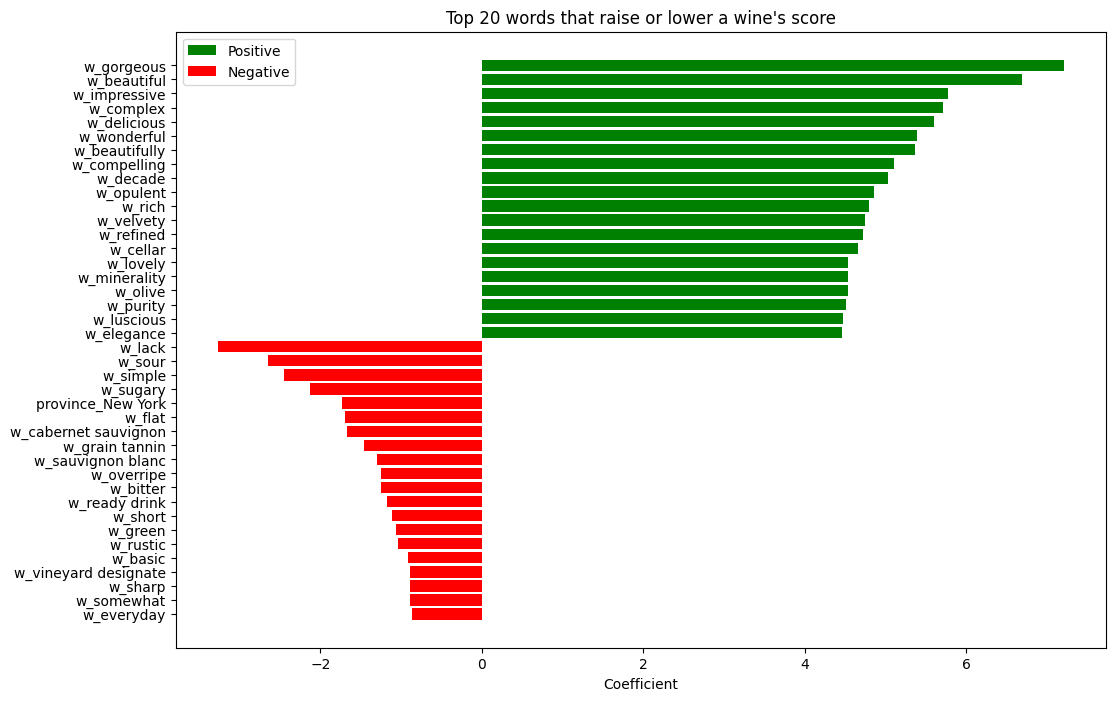

In [23]:
# Create a bar plot to visualize the top 20 positive and the top 20 negative coeffs

import matplotlib.pyplot as plt

selected_coefs = regressor.coef_[selector.get_support()]
labels = [features.columns[i] for i in range(len(features.columns)) if selector.get_support()[i]]

coef_df = pd.DataFrame({
    "feature": labels,
    "coefficient": selected_coefs
})

top_positive = coef_df.sort_values(by="coefficient", ascending=False).head(20)
top_negative = coef_df.sort_values(by="coefficient", ascending=True).head(20)

plt.figure(figsize=(12,8))

plt.barh(top_positive["feature"], top_positive["coefficient"], color='green', label='Positive')
plt.barh(top_negative["feature"], top_negative["coefficient"], color='red', label='Negative')

plt.xlabel("Coefficient")
plt.title("Top 20 words that raise or lower a wine's score")
plt.legend()
plt.gca().invert_yaxis()
plt.show()

**Conclusions**

After selecting the top 500 most informative TF-IDF features using SelectKBest(chi2), the linear regression model maintained a strong performance (MAE ~1.49), showing that many words in the original text were likely noise. The plot above shows which words have the greatest impact on the predicted wine score.

From the plot:

* words with high positive coefficients (shown in green) increase the predicted score → positive, praising descriptions are associated with higher quality wines.

* words with negative coefficients (shown in red) decrease the score → words like “lack”, “simple”, or “flat” indicate lower quality.

This shows that textual descriptions are highly predictive, capturing information that price or categorical features alone cannot provide. Removing them would significantly reduce predictive accuracy.

# (Optional) Exercise 2: Better Text Features for Wine Scoring

In this exercise, you will repeat the same procedure of the previous exercise, but you will use a pre-trained transformer model via the Huggingface Transformers library instead of the TfidfVectorizer.

Remember that extracting embeddings from pretrained models is easily done with the `pipeline("feature-extraction")` class, but this can be a very time consuming process even using GPU accelerators. For this reason, consider using small models (e.g. Distilbert) and possibly select a subset of the training instances to make the process faster.

**Important**: Since you are now using a model trained on naturally-occurring text, any transformation applied to the text should be ignored and the original text should be used.

In [ ]:
# TODO: Reproduce the same pipeline presented above using
# features extracted from a transformer model of your choice.
# You will still use a Linear Regressor, only the feature from
# step 1 will change.

# TODO: Compare the performance of the new model with the original
# models and baselines. Comment whether it is still possible to
# understand the importance of different terms in this new setting.